### Objective

#### Housing Price prediction
Predict a house price based on its correlation with different housing features related to space, construction, location, among others. Exploration of supervised models and its performance evaluation.

#### Methodology
- Loading, visualization and caracterization of data
- Stratified data splitting
- Handling missing values and Multicollinearity
- Encoding categorized strings
- Linear, Multinomial and Polinomial regression
- Cross-validation for Hyperparameters tunning
- Decision tree and Randon Forest classifier
- Clustering with K-nearest neighbors

### Data Collection

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/My Drive/Data_Science/house-prices-data'

In [3]:
DATA_PATH = 'house-prices-data'

In [4]:
def load_data(data_path = DATA_PATH, file_name = "train.csv"):
        csv_path = os.path.join(data_path, file_name)
        return pd.read_csv(csv_path)
df = load_data()

### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Assign values to ordered_categories (Excelent, Good, Average, Poor)

In [6]:
ordered_categories = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu",
                      "GarageFinish", "GarageQual", "GarageCond", "PoolQC"]
mapping = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA":0, "Gd":4, "Av":3, "Mn":2, "No":1, "GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "Fin":3, "RFn":2}
df[ordered_categories] = df[ordered_categories].replace(mapping)
df.drop(columns = "Id", inplace=True)

C:\Users\glgal\AppData\Local\Temp\ipykernel_5720\1967364931.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[ordered_categories] = df[ordered_categories].replace(mapping)


In [7]:
counts = df.nunique()
counts[counts > 40]

LotFrontage       110
LotArea          1073
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
GrLivArea         861
GarageYrBlt        97
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
ScreenPorch        76
SalePrice         663
dtype: int64

#### Visualization of Features
Histogram

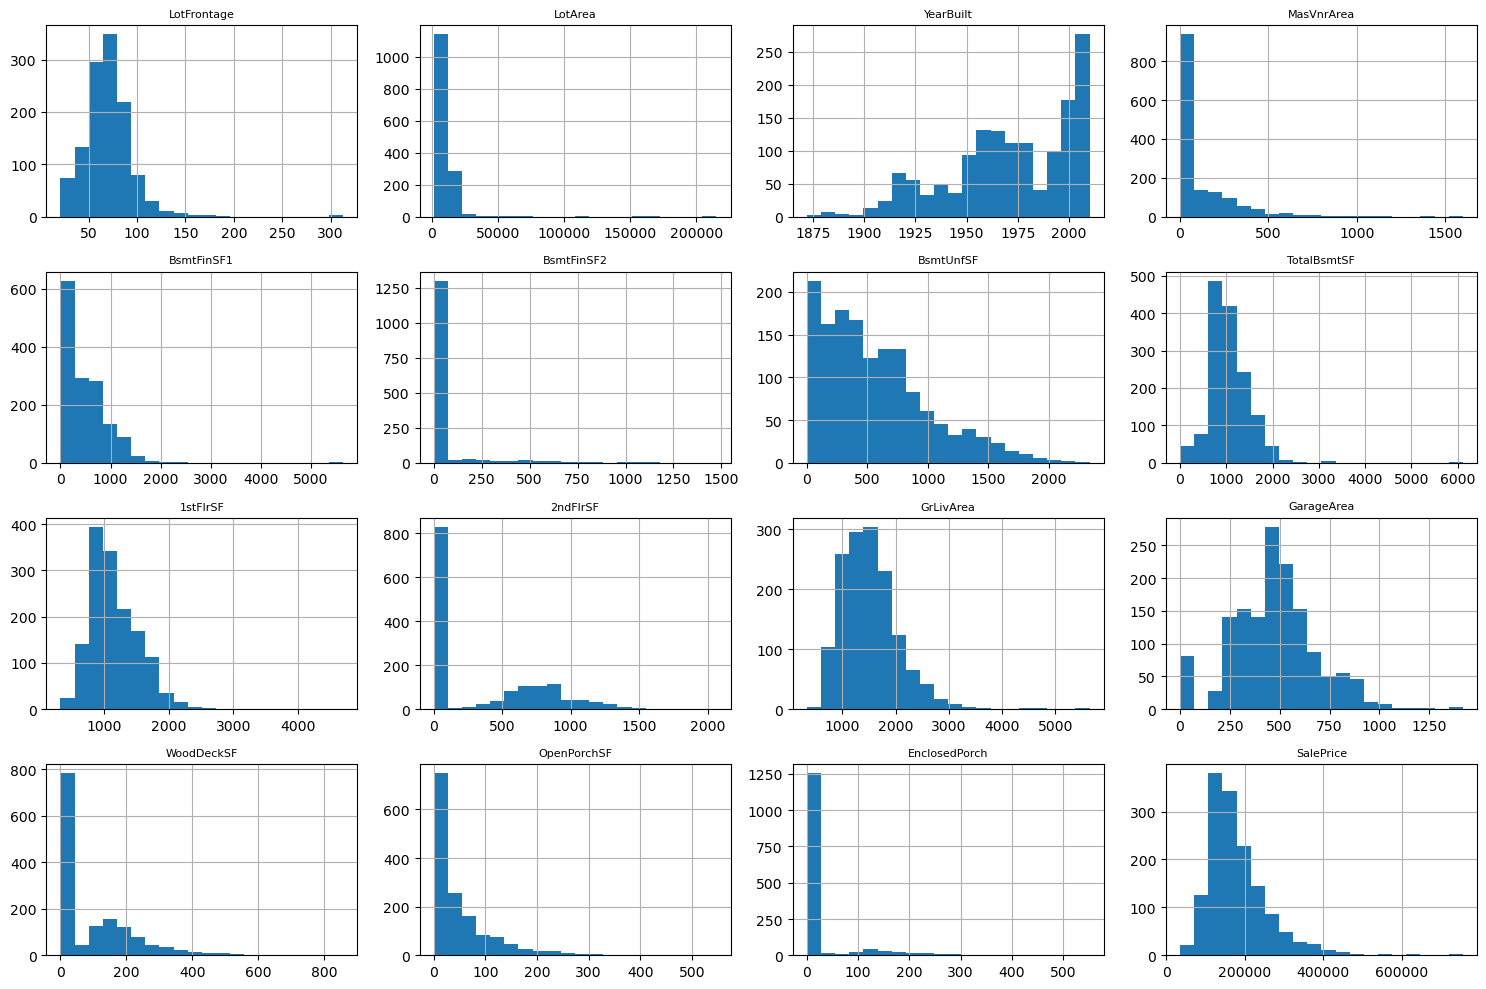

In [8]:
%matplotlib inline
counts = df.nunique()
low_unique = counts[counts > 100].index
axes = df[low_unique].hist(bins=20, figsize=(15,10))
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=8)
plt.tight_layout()
plt.show()

### Data Transformation and Visualization

#### Test dataset creation: Comparing simple and stratified splitting

When you restart the notebook, the split is random again, so new rows end up in the test set or train set. But, as you try new model settings, tune hyperparameters, etc., you may accidentally use all the data for training across different experiments—just not at the same time!

Therefore, it is important to keep the same test set every time I re run the model and adjust the hyperparameters, etc

#### Simple Data split

In [9]:
from sklearn.model_selection import train_test_split
train_set_simple_split, test_set_simple_split = train_test_split(df, test_size=0.2, random_state=42)

#### Stratification
Creation of bins (range of saleprice) based on quantiles in Saleprice

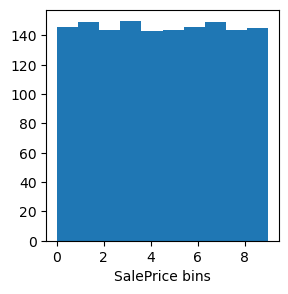

In [10]:
def stratification(df_to_strat):
    df_to_strat["SalePrice_cat"] = pd.qcut(df_to_strat["SalePrice"],  q = 10,  labels= False, duplicates="drop")
    return df_to_strat


test_set = stratification(test_set_simple_split)
train_set = stratification(train_set_simple_split)

df = stratification(df)
fig = plt.figure(figsize  = (3,3))
plt.hist(df["SalePrice_cat"])
plt.xlabel("SalePrice bins")
plt.ylabel("")
plt.show()

#### Robust Datasplit with Stratification
Data splitting based on the saleprice bins to ensure price groups are equally represented in the train and test dataset

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["SalePrice_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [12]:
proportion_comparison = pd.DataFrame()
proportion_comparison["original"] = df["SalePrice_cat"].value_counts() / len(df)
proportion_comparison["random"] = train_set["SalePrice_cat"].value_counts() / len(train_set)
proportion_comparison["stratified"] = strat_train_set["SalePrice_cat"].value_counts() / len(strat_train_set)
proportion_comparison.sort_index(axis=0, ascending=True, inplace=True, kind='quicksort')
proportion_comparison

,original,random,stratified
SalePrice_cat,,,
0,0.100000,0.101027,0.100171
1,0.102055,0.105308,0.101884
2,0.098630,0.095034,0.098459
3,0.102740,0.099315,0.102740
4,0.097945,0.102740,0.098459
5,0.098630,0.098459,0.098459
6,0.100000,0.102740,0.100171
7,0.102055,0.098459,0.101884
8,0.098630,0.096747,0.098459


In [13]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("SalePrice_cat", axis=1, inplace=True)

#### Correlation between features

In [ ]:
housing = strat_train_set.copy()
housing_num = housing.select_dtypes(include = 'number')
corr_matrix = housing_num.corr(numeric_only=True)
corr_matrix["SalePrice"].sort_values(ascending=False)[4]

C:\Users\glgal\AppData\Local\Temp\ipykernel_5720\4266337453.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr_matrix["SalePrice"].sort_values(ascending=False)[4]


np.float64(0.6602033617589087)

In [15]:
from pandas.plotting import scatter_matrix
attributes = ["SalePrice","OverallQual", "GrLivArea", "TotalBsmtSF", "GarageCars", "GarageArea", "1stFlrSF"]

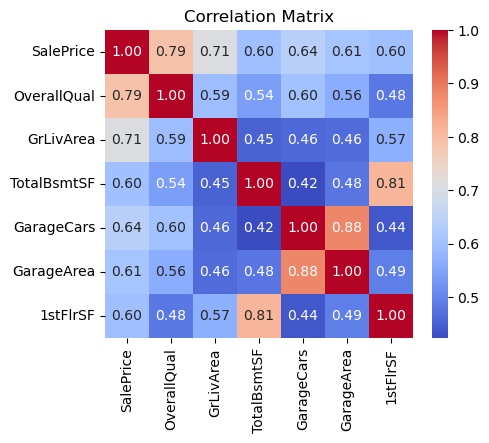

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(5, 4))
corr = housing[attributes].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

#### Missing values

 You have three options:
1. Get rid of the corresponding rows (for low number of null vallues and missingness appears random)
2. Get rid of the whole attribute. (If missing values are >30-40% and column is not critical in model performance)
3. Set the values to some value (zero, the mean, the median, etc.)\

Count of missing values:

In [17]:
def check_null_values(df):
    null_counts = df.isnull().sum()
    null_table = null_counts[null_counts > 0].reset_index()
    null_table = null_table.sort_values(by = 0, ascending = False)
    null_table.rename(columns = {"index": "Attribute", 0: "Null Count"}, inplace = True)
    return null_table
null_table = check_null_values(housing)
null_table.head(7)

,Attribute,Null Count
16,PoolQC,1161
18,MiscFeature,1125
1,Alley,1095
17,Fence,943
2,MasVnrType,693
10,FireplaceQu,555
0,LotFrontage,212


Deleting columns whose NaN values are higher than 40%

In [18]:
col_delete = null_table[null_table["Null Count"] > len(housing)*0.5 ]["Attribute"].values
housing.drop(columns = col_delete, inplace = True)

#### Imputer

SimpleImputer

In [19]:
# nulls rows could be deleted for "MasVnrArea" because it has only 5 missing values, 0.33% of the total rows: housing.dropna(subset=["MasVnrArea"], inplace=True)
# cols with null values will be filled with the mean value of the attribute, missing values for each column represent less than 15%
from sklearn.impute import SimpleImputer

categorical_cols = list(housing.select_dtypes(include = ['object', 'category']))
imputer_cat = SimpleImputer(strategy="most_frequent")
housing[categorical_cols] = imputer_cat.fit_transform(housing[categorical_cols])

housing_num = housing.select_dtypes(include = 'number')
imputer = SimpleImputer(strategy="mean")
imputer.fit(housing_num) # imputer.statistics_ will contain the mean values of each column

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing[housing_num.columns] = housing_tr

### Feature Engineering & Selection

#### Multicollinearity

In [20]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.feature_selection import mutual_info_regression

def select_by_corr_clustering(df, target, corr_threshold=0.8, pearson_tol=0.3, mi_random_state=0):
    """
    1) Build |corr| matrix among predictors.
    2) Convert to a distance matrix d = 1 - |corr|.
    3) Hierarchical clustering on distances.
    4) From each cluster, keep ONE feature:
       - Highest |Pearson(feature, target)|
       - If |Pearson| within pearson_tol, choose higher MI(feature, target).
    """

    df = df.select_dtypes(include='number').copy()
    if target not in df.columns:
        raise KeyError(f"Target '{target}' not found in df")
    if df.isna().any().any():
        raise ValueError("NaNs detected: impute before running selection")
    X = df.drop(columns=[target])
    y = df[target]

    pearson = df.corr()[target].abs().drop(target).fillna(0.0)
    mi = pd.Series(
        mutual_info_regression(X, y, random_state=mi_random_state),
        index=X.columns
    ).fillna(0.0)

    corr = X.corr().abs().fillna(0.0)
    dist = 1 - corr
    np.fill_diagonal(dist.values, 0.0)

    condensed = squareform(dist.values, checks=False)
    Z = linkage(condensed, method='average')

    distance_cut = 1 - corr_threshold
    clusters = fcluster(Z, t=distance_cut, criterion='distance')
    cluster_map = pd.DataFrame({'feature': corr.columns, 'cluster': clusters})

    selected = []
    for cid, grp in cluster_map.groupby('cluster'):
        feats = grp['feature'].tolist()

        # pick best by Pearson; if |diff| <= pearson_tol, break tie by MI
        feats_sorted = sorted(
            feats,
            key=lambda f: (round(pearson.get(f, 0.0), 12), round(mi.get(f, 0.0), 12)),
            reverse=True
        )

        best = feats_sorted[0]
        if len(feats_sorted) >= 2:
            f1, f2 = feats_sorted[0], feats_sorted[1]
            if abs(pearson[f1] - pearson[f2]) <= pearson_tol:

                best = f1 if mi[f1] >= mi[f2] else f2

        selected.append(best)
    return selected

selected_features = select_by_corr_clustering(housing, 'SalePrice', corr_threshold=0.85, pearson_tol=0.3)
print(selected_features)
selected_features.append('SalePrice')
housing_clean = housing[selected_features]

['LowQualFinSF', 'PoolArea', 'OverallCond', 'ExterCond', 'BsmtCond', 'BsmtHalfBath', 'GarageQual', 'GarageCond', 'EnclosedPorch', 'MSSubClass', 'KitchenAbvGr', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'BsmtExposure', 'GrLivArea', 'TotRmsAbvGrd', '2ndFlrSF', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotalBsmtSF', '1stFlrSF', 'LotFrontage', 'Fireplaces', 'LotArea', 'GarageCars', 'YearBuilt', 'GarageYrBlt', 'BsmtQual', 'OverallQual', 'ExterQual', 'KitchenQual', 'YearRemodAdd', 'GarageFinish', 'HeatingQC', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinType2', 'BsmtFinSF2', 'FireplaceQu', 'ScreenPorch', 'MoSold', 'YrSold', '3SsnPorch', 'MiscVal']


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif_df = pd.DataFrame()
    vif_df["variables"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif_df = vif_df.sort_values(by = "VIF", ascending = False).reset_index(drop = True)
    return (vif_df)

def correlation_cleaning_1(df, target1):
    df_features = df.drop(target1, axis=1)
    df_cleaned = df_features.select_dtypes(include = 'number')
    vif = calc_vif(df_cleaned)

    while vif["VIF"].max() > 5:
        var = vif.loc[vif["VIF"].idxmax(), "variables"]
        df_cleaned.drop(columns = var, inplace = True)
        vif = calc_vif(df_cleaned)
    return df_cleaned, vif

features_num, final_vif = correlation_cleaning_1(housing_clean, "SalePrice")

c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


#### Handling with strings

If text is not arbitrary and unique values are limited, then the attribute can be a categorical attribute and can be converted to a numerical value.

In [22]:
pd.set_option('display.max_columns', None)

In [23]:
features_cat = housing.select_dtypes(include=['object', 'category'])
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(features_cat) # 2D array with categorical values
ordinal_encoder.categories_[0:4]

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object)]

#### *one-hot encoding* to not ordered categories

only one attribute will be equal to 1 (hot), while the others will be 0 (cold).
NOTE: When categorical attribute has a large number of categories, one-hot encoding can slow down the training and performance. categories can be replaced with useful numerical features (e.i. country code by GDP per capita and population). Alternatively, categories can be replaced by a learnable, low-dimensional vector called an embedding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
features_cat_1hot = cat_encoder.fit_transform(features_cat) # sparse matrix with categorical values. Only saves the non-zero values to save memory
#housing_cat_1hot.toarray() # convert sparse matrix to dense array for better visualization

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 29200 stored elements and shape (1168, 173)>

#### Robust scaler
Features with very different scales are harder to visualize and most important, generate a bias in ML models.  

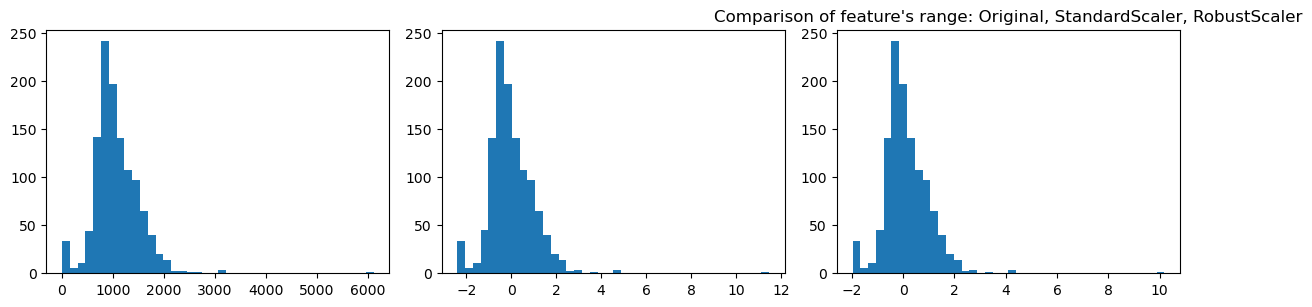

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
test = housing[["TotalBsmtSF"]]

standard_scaler = StandardScaler()
x_standard = standard_scaler.fit_transform(test)

robust_scaler = RobustScaler()
x_robust = robust_scaler.fit_transform(test)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].hist(housing["TotalBsmtSF"], bins=40, label = 'TotalBsmtSF')
axs[1].hist(x_standard, bins=40, label = 'Stardard_TotalBsmtSF')
axs[2].hist(x_robust, bins=40, label = 'Robust_TotalBsmtSF')
plt.tight_layout()
plt.title("Comparison of feature's range: Original, StandardScaler, RobustScaler")
plt.show()

### Pipeline Building

Previously missing values were treated with the sklearn SimpleImputer by calling manually the fit and transform methods. Nevertheless, Pipelines can run this and more classes in a row

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

# full pipeline that handles the transformation for the two groups of columns (numerical and categorical). Each tuple has: a name, Transformer and a list of columns
# the columns not listed will be dropped by default. to prevent this we can specify "pas through"

num_pipeline = Pipeline([
    ('std_scaler', RobustScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, selector(dtype_include = np.number)), #returns a dense matrix
    ('cat', OneHotEncoder(handle_unknown="ignore"), selector(dtype_include = object)) #returns a sparse matrix
])

features = features_num.join(features_cat, how = 'left')
features_prepared = full_pipeline.fit_transform(features)

# ColumnTransformer returns a sparse matrix if density (ratio of non zero cells) is lower than 0.3 (By default)
# here, as matrix had a large amount of non zero cells, it returns a dense matrix

#to call an attribute use named_transformers_["transformer's instance"].attribute
#full_pipeline.named_transformers_['cat'].categories_

labels = housing_clean["SalePrice"].copy()
y_scaler = RobustScaler()
labels_scaled = y_scaler.fit_transform(labels.values.reshape(-1,1)).flatten()

#### Test set transformation

In [27]:
def preprocessing_test_set(df_train_final, df_test, preprocessing_pipeline, labels_scaler, target):
  #null value imputing
  categorical_cols = list(imputer_cat.feature_names_in_)
  numerical_cols = list(imputer.feature_names_in_)
  df_test.loc[:,categorical_cols] = imputer_cat.transform(df_test[categorical_cols])
  df_test.loc[:,numerical_cols] = imputer.transform(df_test[numerical_cols])

  #keep only columns of train set
  columns_train = df_train_final.columns
  df_test_final = df_test[columns_train].copy()

  #scaling and encoding categorical variables
  test_set_preprocessed = preprocessing_pipeline.transform(df_test_final)
  #labels
  labels = df_test[target].copy()
  labels_scaled = labels_scaler.transform(labels.values.reshape(-1,1)).flatten()
  return test_set_preprocessed, labels, labels_scaled

test_transformed, test_y, test_y_scaled = preprocessing_test_set(features, strat_test_set, full_pipeline, y_scaler, "SalePrice")

### Linear and Polynomial Model

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lin_reg = LinearRegression() # Use the Ordinary Least Squares to calculate coefficients tetha by minimizing MSE. Gradient descent is an algorithm for this too
lin_reg.fit(features_prepared, labels_scaled)

housing_pred_scaled = lin_reg.predict(features_prepared)
housing_pred = y_scaler.inverse_transform(housing_pred_scaled.reshape(-1,1)).ravel()
lin_mae = mean_absolute_error(labels, housing_pred) #Average difference between the predicted and actual values
r2 = lin_reg.score(features_prepared, labels_scaled) #R² determination coefficient

test_pred_scaled = lin_reg.predict(test_transformed)
test_pred = y_scaler.inverse_transform(test_pred_scaled.reshape(-1,1)).ravel()
test_lin_mae = mean_absolute_error(test_y, test_pred) #Average difference between the predicted and actual values
test_r2 = lin_reg.score(test_transformed, test_y_scaled) #R² determination coefficient

print(f'Linear Regression train set: R²: {r2}, MAE: {lin_mae}, Sale price range: {labels.min(), labels.max()}')
print(f'Test set: R²: {test_r2}, MAE: {test_lin_mae}, Sale price range: {test_y.min(), test_y.max()}')

Linear Regression train set: R²: 0.8610443404860743, MAE: 21087.897404819138, Sale price range: (34900.0, 755000.0)
Test set: R²: 0.7772326142316369, MAE: 26656.901589163677, Sale price range: (35311, 625000)


#### Stochastic Gradient Descent

In [29]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    loss="huber", # less focus and correction of outliers
    penalty="l2", # penalty hyperparameter of Ridge Regression
    learning_rate="adaptive",
    eta0=0.001,
    max_iter=4000,
    tol=1e-3,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30,
    average=True,
    random_state=10
)
sgd_reg.fit(features_prepared, labels_scaled)
sgd_housing_pred_scaled = sgd_reg.predict(features_prepared)
sgd_housing_pred = y_scaler.inverse_transform(sgd_housing_pred_scaled.reshape(-1,1)).ravel()
sgd_mse = mean_squared_error(labels, sgd_housing_pred) #Average difference between the predicted and actual values
sgd_rmse = np.sqrt(sgd_mse)  #square root #RMSE: Root Mean Squared Error
sgd_r2 = sgd_reg.score(features_prepared, labels_scaled) #R² determination coefficient
print(f'Stochastic Gradient Descent R²: {sgd_r2}, RMSE: {sgd_rmse}')

Stochastic Gradient Descent R²: 0.5103210195309846, RMSE: 55457.677111635094


#### Huber Regressor Linear model

In [35]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor(max_iter=4500, alpha=1e-3, epsilon=1.5, tol=1e-4)
huber.fit(features_prepared, labels_scaled)

huber_pred_scaled = huber.predict(features_prepared)
huber_pred = y_scaler.inverse_transform(huber_pred_scaled.reshape(-1,1)).ravel()
lin_mae = mean_absolute_error(labels, huber_pred) #Average difference between the predicted and actual values
r2 = r2_score(labels, huber_pred) #R² determination coefficient

print(f'Huber Regression: R²: {r2}, MAE: {lin_mae}, Sale price range: {labels.min(), labels.max()}')

Huber Regression: R²: 0.8185715868414651, MAE: 20868.292950046427, Sale price range: (34900.0, 755000.0)


c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### Polynomial Regression

In [30]:
from sklearn.preprocessing import PolynomialFeatures

num_pipeline_poly = Pipeline([
    ('std_scaler_2', RobustScaler()),
    ('poly_features', PolynomialFeatures(degree = 2, include_bias = False))
])

full_pipeline_poly = ColumnTransformer([
    ('num_poly', num_pipeline_poly, selector(dtype_include=np.number)),
    ('cat_poly', OneHotEncoder(), selector(dtype_include=object))
])
feat_prepared_poly = full_pipeline_poly.fit_transform(features)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(feat_prepared_poly, labels_scaled)
lin_reg_poly_pred_scaled = lin_reg_poly.predict(feat_prepared_poly)
lin_reg_poly_pred = y_scaler.inverse_transform(lin_reg_poly_pred_scaled.reshape(-1,1)).ravel()
lin_reg_poly_rmse = np.sqrt(mean_squared_error(labels, lin_reg_poly_pred))
lin_reg_poly_r2 = lin_reg_poly.score(feat_prepared_poly, labels_scaled)
print(f'Polynomial Regression 2nd grade R²: {lin_reg_poly_r2}, RMSE: {lin_reg_poly_rmse}')

Polynomial Regression 2nd grade R²: 0.9137909152608406, RMSE: 23269.254033312915


#### Polynomial Regression with stochastic gradient descend algorithm with Lasso Regularization
(Lasso regularization tends to eliminate less important features)

In [31]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    loss="huber",
    penalty="l1", # penalty hyperparameter of Ridge Regression
    learning_rate="adaptive",
    eta0=0.001,
    max_iter=4000,
    tol=1e-3,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    average=True,
    random_state=10
)
sgd_reg.fit(feat_prepared_poly, labels_scaled)
sgd_housing_pred_scaled = sgd_reg.predict(feat_prepared_poly)
sgd_housing_pred = y_scaler.inverse_transform(sgd_housing_pred_scaled.reshape(-1,1)).ravel()
sgd_mse = mean_squared_error(labels, sgd_housing_pred) #Average difference between the predicted and actual values
sgd_rmse = np.sqrt(sgd_mse)  #square root #RMSE: Root Mean Squared Error
sgd_r2 = sgd_reg.score(feat_prepared_poly, labels_scaled) #R² determination coefficient
print(f'Stochastic Gradient Descent R²: {sgd_r2}, RMSE: {sgd_rmse}')

Stochastic Gradient Descent R²: -219545478006150.6, RMSE: 1174270611421.142


#### Model Evaluation and Tuning

##### Cross-validation - Linear Regression
dataset is splitted in 10 smaller datasets. Model is trained 10 times to get an array with the 10 RMSE

In [32]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()
lin_reg_ttr = TransformedTargetRegressor(
    regressor = lin_reg,
    transformer = RobustScaler()
)
scores = cross_val_score(lin_reg_ttr, features_prepared, labels, scoring="neg_mean_absolute_error", cv=10)
def display_scores(scores):
    print("Linear Regression - Mean (mean of MAEs):", scores.mean())
    print(f"Standard deviation: {scores.std()}, std%: {np.round(scores.std()/scores.mean(),4)*100}%")
    #how stable is the model. if >30% model is overfitted if training in the whole train test has good R2
display_scores(-scores)

Linear Regression - Mean (mean of MAEs): 26420.556939804792
Standard deviation: 1984.2923615020752, std%: 7.51%


##### Cross-validation - Polynomial Regression

In [33]:
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()
polylomial_reg_ttr = TransformedTargetRegressor(
    regressor = lin_reg,
    transformer = RobustScaler()
)
scores = cross_val_score(polylomial_reg_ttr, feat_prepared_poly, labels, scoring="neg_mean_absolute_error", cv=10)
def display_scores(scores):
    print("Polynomial Regression Mean (mean of MAEs):", scores.mean()) #Mean Absolute Error
    print(f"Standard deviation: {scores.std()}, std%: {np.round(scores.std()/scores.mean(),4)*100}%")
    #how stable is the model. if >30% model is overfitted
display_scores(-scores)

Polynomial Regression Mean (mean of MAEs): 40063.40386375642
Standard deviation: 25800.31566515884, std%: 64.4%



### Logistic Model

#### Choosing a categorical variable to regress

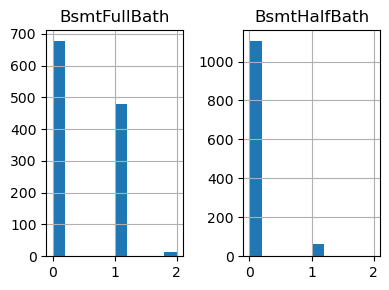

In [ ]:
candidates = ["LandSlope", "Street", "CentralAir", "BsmtFullBath", "BsmtHalfBath"]
features[candidates].hist(bins=10, figsize=(4,3))
plt.tight_layout()
plt.show()
#BsmtFullBath has a decent data distribution and good data amount

<Figure size 300x200 with 0 Axes>

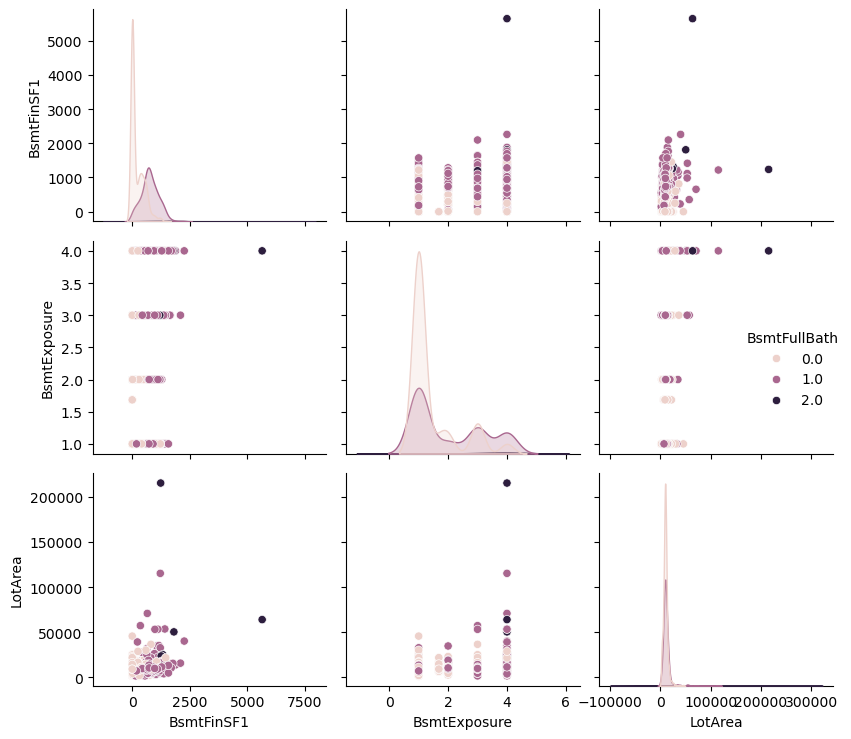

In [75]:
fig = plt.figure(figsize  = (3,2))
sample = features_num.corr()["BsmtFullBath"].sort_values(ascending=False).head(4)
sample = np.array(sample.index)
sample = features_num[sample]
sns.pairplot(data = sample, hue = 'BsmtFullBath')
plt.tight_layout()
plt.show()

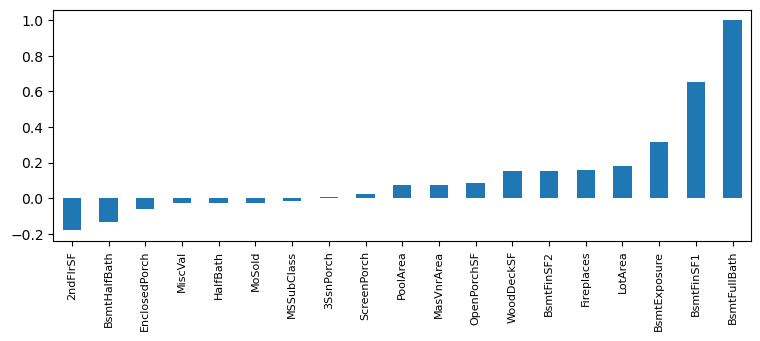

In [93]:
fig, ax = plt.subplots(figsize  = (9,3))
features_num.corr()["BsmtFullBath"].sort_values(ascending=True).plot(kind = 'bar')
ax.tick_params(axis = 'x', labelsize=8)
plt.show()

In [39]:
from sklearn.base import clone

X2 = features.drop("BsmtFullBath", axis = 1)
y2 = features["BsmtFullBath"].values

full_pipeline2 = clone(full_pipeline)
X2_transformed = full_pipeline2.fit_transform(X2)
scaler2 = RobustScaler()
y2_scaled = scaler2.fit_transform(y2.reshape(-1,1)).flatten()

BsmtFullBath feature has three possible values: 0, 1, 2.

- class_weight: Because of the low representation of class 2, it is set as "Balanced".

- Because these classes are dependent and not random classes, Multinomial regression is applied and not One vs Rest

- solver: newton-cg is good for multiclass classification problems

#### Model Tuning

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = [
 {'class_weight': [None, 'balanced'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
 ]
# liblinear doesn’t support multinomial; it forces OvR
log_reg_grid = LogisticRegression()
grid_search = GridSearchCV(log_reg_grid, param_grid, cv = 5, scoring = "accuracy", return_train_score = True)
grid_search.fit(X2_transformed, y2)
print(f'Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}')

c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best parameters: {'class_weight': None, 'solver': 'newton-cg'}, Best score: 0.8236565056307545


In [41]:
log_reg = LogisticRegression(solver = 'newton-cg')
log_reg.fit(X2_transformed, y2)
y2_pred_scaled = log_reg.predict(X2_transformed)
y2_pred = scaler2.inverse_transform(y2_pred_scaled.reshape(-1,1)).ravel()
log_pred_mae = mean_absolute_error(y2, y2_pred) #Average difference between the predicted and actual values
r2 = log_reg.score(X2_transformed, y2) #accuracy
print(f'Linear Regression: R²: {r2}, MAE: {log_pred_mae}, Sale price range: {y2.min(), y2.max()}')

Linear Regression: R²: 0.8818493150684932, MAE: 0.11815068493150685, Sale price range: (np.float64(0.0), np.float64(2.0))


#### Model Evaluation

In [42]:
#importance of each attribute
log_reg.coef_[1][:4]

array([ 8.34683635e-04, -1.70517703e+00,  2.86819607e-02,  1.15182763e-01])

Axes(0.125,0.11;0.775x0.77)


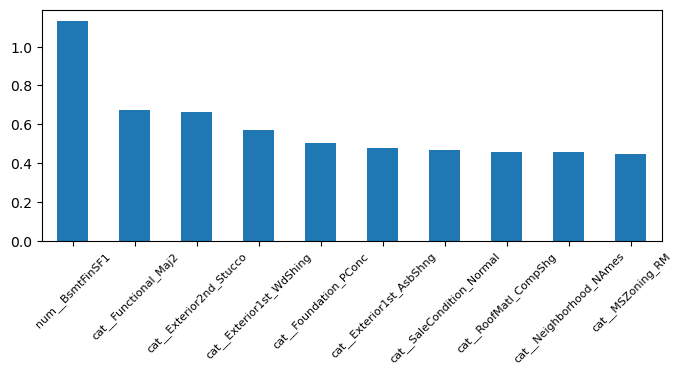

In [111]:
features_name = full_pipeline2.get_feature_names_out()
weights_0 = pd.Series(log_reg.coef_[1], index = features_name)
fig, ax = plt.subplots(figsize  = (8,3))
print(weights_0.sort_values(ascending=False)[:10].plot(kind = 'bar'))
ax.tick_params(axis = 'x', labelsize = 8)
plt.xticks(rotation=45, fontsize=8)
plt.show()

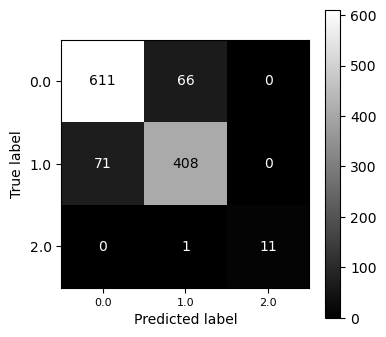

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize  = (4,4))
cm = confusion_matrix(y2, y2_pred, labels = log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap = 'gray', ax = ax)
ax.tick_params(axis = 'x', labelsize = 8)
plt.show()

### Decision Tree model

Possible features for classification:


*   ExterQual
*   ExterCond
*   HeatingQC
*   KitchenQual
*   GarageCond






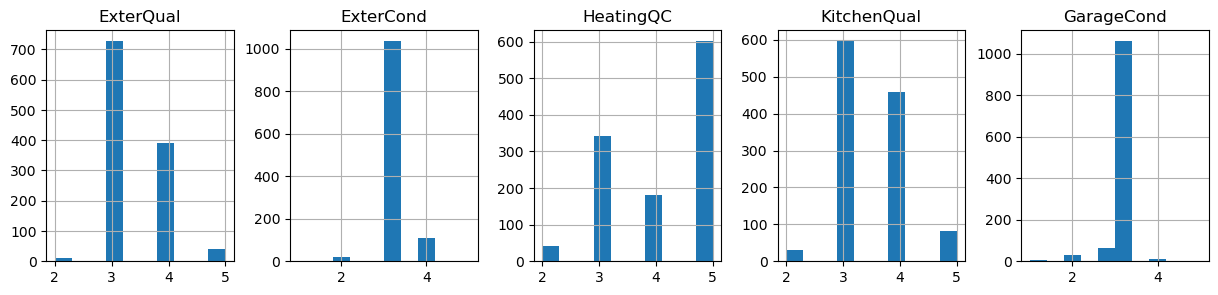

In [45]:
%matplotlib inline
candidates = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "GarageCond"]
housing[candidates].hist(bins=10, layout=(1, 5), figsize=(15,3))
plt.show()

#### cleaning and transformation

In [46]:
num_pipeline3 = Pipeline([
    ('std_scaler', RobustScaler())
])

full_pipeline3 = ColumnTransformer([
    ('num', num_pipeline3, selector(dtype_include = np.number)), #returns a dense matrix
    ('cat', OneHotEncoder(handle_unknown="ignore"), selector(dtype_include = object)) #returns a sparse matrix
])

features_cat2 = housing.select_dtypes(include=['object', 'category'])
features_num2, final_vif2 = correlation_cleaning_1(housing.drop("SalePrice", axis = 1), "HeatingQC")

features3 = features_num2.join(features_cat2, how = 'left')

X3 = full_pipeline3.fit_transform(features3)
y3 = housing["HeatingQC"].copy()
y3_scaler = RobustScaler()
y3_scaled = y3_scaler.fit(y3.values.reshape(-1,1))
#transformation of test set
test_transformed_3, test_y3, test_y3_scaled = preprocessing_test_set(features3, strat_test_set, full_pipeline3, y3_scaler, "HeatingQC")

c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


#### Decision Tree training

In [47]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 17, random_state=42, criterion = 'gini')
#max_depth controls the number of levels. random_state controls randomness. dictates which of the equally good features is selected for splitting a node
#criterion cane be 'gini', 'entropy'
tree.fit(X3, y3)
y3_pred = tree.predict(X3)

In [48]:
from sklearn.metrics import accuracy_score, f1_score

train_accuracy = accuracy_score(y3, y3_pred)
test_accuracy = accuracy_score(test_y3, tree.predict(test_transformed_3))

train_f1_macro = f1_score(y3, y3_pred, average = 'macro')
test_f1_macro = f1_score(test_y3, tree.predict(test_transformed_3), average = 'macro')

train_f1_weighted = f1_score(y3, y3_pred, average = 'weighted')
test_f1_weighted = f1_score(test_y3, tree.predict(test_transformed_3), average = 'weighted')

print(f"""Train accuracy: {train_accuracy}. \nTrain f1 macro (mean of f1 score for each label): {train_f1_macro} \nTrain f1_weighted (F1 scores mean Weighted by the number of true instances for each label): {train_f1_weighted}""")
print(f"""\nTest accuracy: {test_accuracy}. \nTest f1 macro: {test_f1_macro} \nTest f1_weighted: {test_f1_weighted}""")

Train accuracy: 0.6601027397260274. 
Train f1 macro (mean of f1 score for each label): 0.47350145046091513 
Train f1_weighted (F1 scores mean Weighted by the number of true instances for each label): 0.6228693382053809

Test accuracy: 0.6198630136986302. 
Test f1 macro: 0.3555095201391933 
Test f1_weighted: 0.5617526437916127


In [49]:
plt.figure(figsize=(4, 4))
cm_tree = confusion_matrix(y3, y3_pred, labels = tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_tree, display_labels= tree.classes_)
disp.plot(cmap = 'gray')

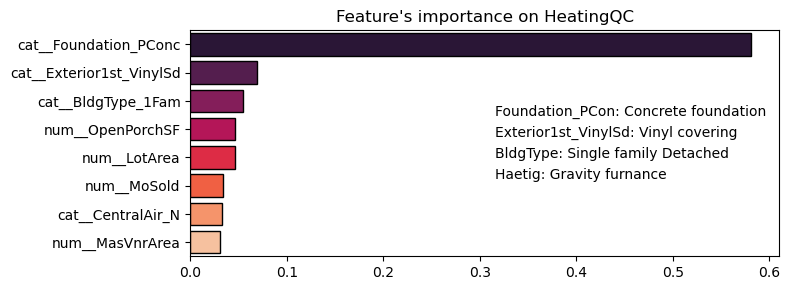

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = tree.feature_importances_
columns_3 = full_pipeline3.get_feature_names_out()
df_importances = pd.DataFrame([importances], columns = columns_3)
df_importances.sort_values(axis=1, by = 0, ascending = False, inplace = True)
#barplot
fig = plt.figure(figsize  = (8,3))
ax = sns.barplot(df_importances[df_importances.columns[:8]], palette = 'rocket', saturation =2.0, edgecolor = 'black', linewidth = 1, orient = 'h')
#legend
glossary = ["Foundation_PCon: Concrete foundation", "Exterior1st_VinylSd: Vinyl covering", "BldgType: Single family Detached", "Haetig: Gravity furnance"]
ax.legend(labels = glossary, loc = 'center right', frameon = False, handlelength=0, handletextpad=0,)
plt.title(f"Feature's importance on HeatingQC")
plt.tight_layout()
plt.show()

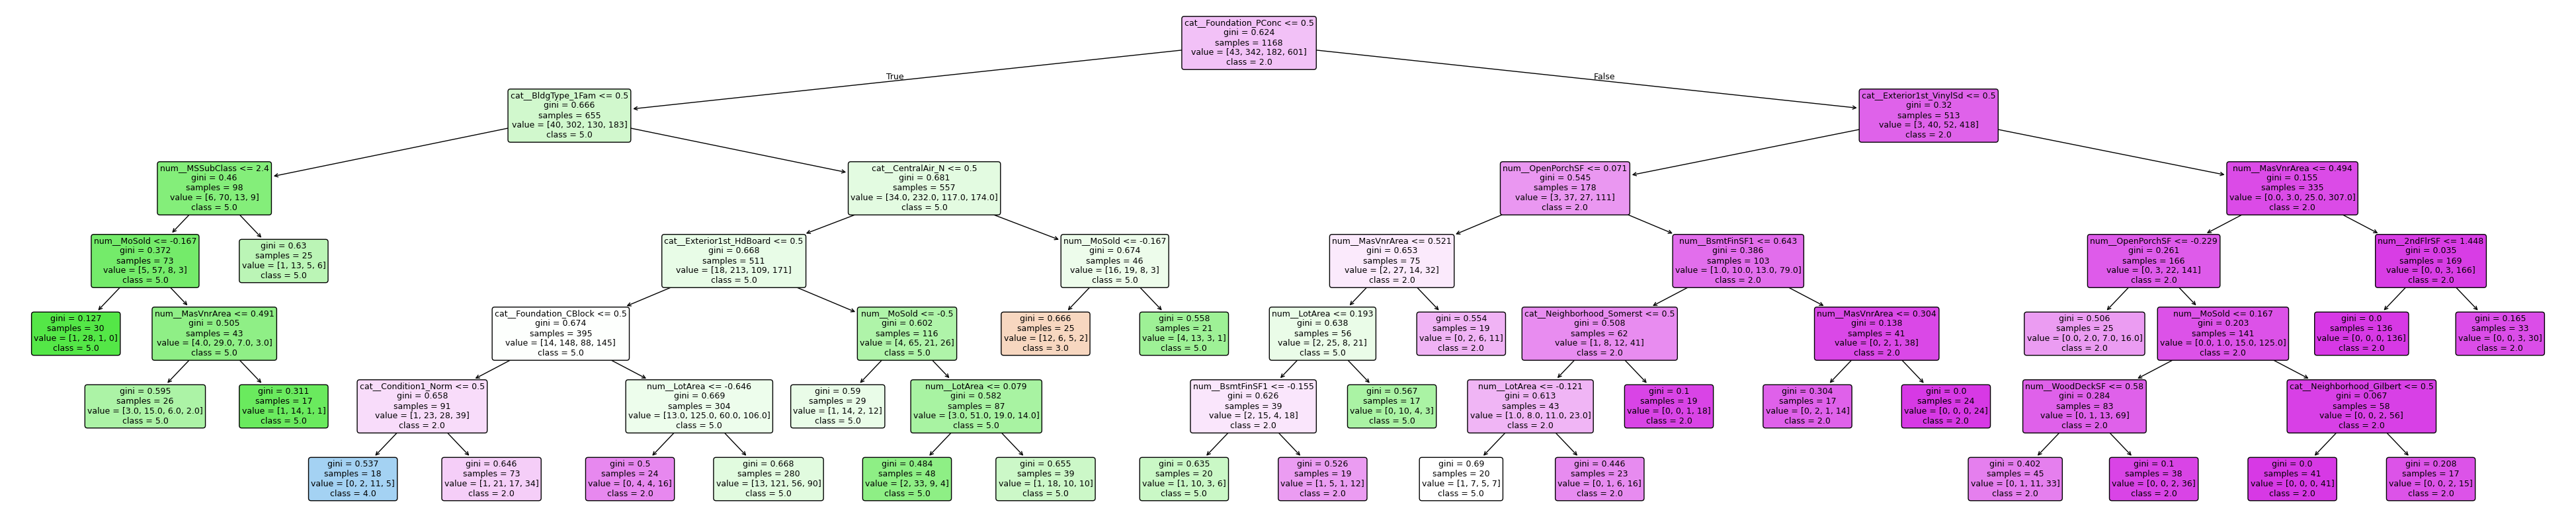

In [51]:
from sklearn.tree import plot_tree
class_names3 = list(map(str, y3.unique()))
plt.figure(figsize=(50, 10))
plot_tree(tree, feature_names = columns_3, class_names = class_names3, filled=True, rounded=True, fontsize = 9)
plt.show()

### Random Forest Classifier

#### Model Training

In [52]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 10, random_state=42)
random_forest.fit(X3, y3)
y_train_pred_random = random_forest.predict(X3)
y_test_pred_random = random_forest.predict(test_transformed_3)

#### Model Evaluation

In [53]:
train_acc_random = accuracy_score(y3, y_train_pred_random)
test_acc_random = accuracy_score(test_y3, y_test_pred_random)
print(f"Train accuracy: {train_acc_random}")
print(f"Test accuracy: {test_acc_random}")

Train accuracy: 0.9914383561643836
Test accuracy: 0.6027397260273972


In [54]:
feature_importances_random = pd.DataFrame(random_forest.feature_importances_,
                                   index = columns_3,
                                   columns=['importance']).sort_values('importance', ascending=False)

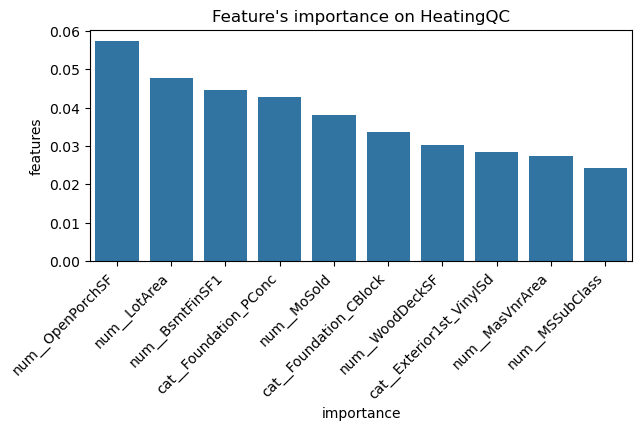

In [118]:
fig = plt.figure(figsize  = (7,3))
sns.barplot(x = feature_importances_random.index[:10], y = feature_importances_random.importance[:10])
plt.xlabel("importance")
plt.ylabel("features")
plt.title("Feature's importance on HeatingQC")
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.show()

In [56]:
cm = confusion_matrix(test_y3, y_test_pred_random)
print(f'Confusion matrix\n{cm}')

Confusion matrix
[[  0   0   1   0   0]
 [  0   0   3   0   3]
 [  0   2  57   7  20]
 [  0   0  25   7  27]
 [  0   0  20   8 112]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(test_y3, y_test_pred_random))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         6
           3       0.54      0.66      0.59        86
           4       0.32      0.12      0.17        59
           5       0.69      0.80      0.74       140

    accuracy                           0.60       292
   macro avg       0.31      0.32      0.30       292
weighted avg       0.55      0.60      0.57       292



c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\glgal\anaconda3\envs\env_1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Gradient Boosting Model
next estimator is trained with the residuals errors made by previous estimator.
+ early stopping until error doesn't change significantly

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 1000):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X3, y3)
  y3_pred_gbrt = gbrt.predict(X3)
  val_error = mean_squared_error(y3, y3_pred_gbrt)
  if val_error < 0.997 * min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
        break # early stopping

In [59]:
gbrt.n_estimators

306

In [60]:
train_acc_gbrt = accuracy_score(y3, np.round(y3_pred_gbrt, decimals = 0))
#test_acc_random = accuracy_score(test_y3, y_test_pred_random)
print(f"Train accuracy: {train_acc_gbrt}")
#print(f"Test accuracy: {test_acc_random}")

Train accuracy: 0.6138698630136986


### Clustering Model

#### Multicolinearity by PCA (Principle Components Analysis)

to do Kmeans with SalePrice and any variable highly correlated to it.

After VIF (50 variables):
SalePrice
SalePrice	1.000000
Fireplaces	0.461925
MasVnrArea	0.447998
BsmtExposure	0.359369
WoodDeckSF	0.343958
2ndFlrSF	0.333698
OpenPorchSF	0.301856
HalfBath	0.290857
LotArea	0.274809
BsmtFullBath	0.226935
BsmtUnfSF	0.215237
ScreenPorch	0.112756
PoolArea	0.103531
3SsnPorch	0.048304

In [61]:
features2 = housing.select_dtypes(include=np.number)
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#scaler = RobustScaler()
scaler = StandardScaler()
features2_scaled = scaler.fit_transform(features2)
from sklearn.decomposition import PCA
pca = PCA()
features2_scaled_pca = pca.fit_transform(features2_scaled)

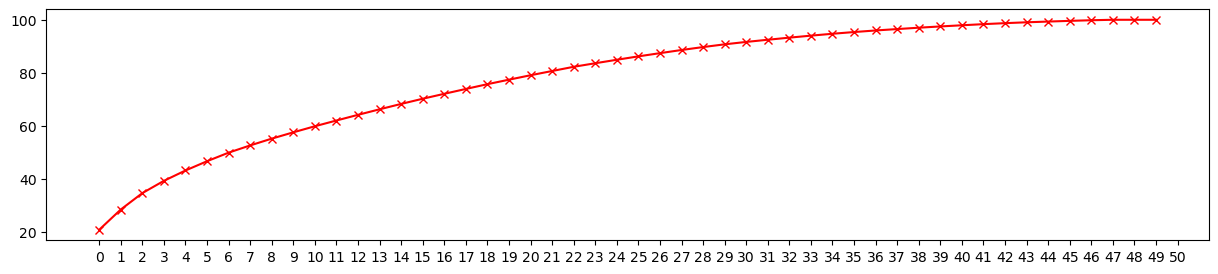

In [62]:
var = pca.explained_variance_ratio_
cum_var =  np.cumsum(np.round(var,decimals = 5)*100)
plt.figure(figsize = (15,3))
plt.plot(cum_var, 'r-x')
plt.xticks(range(0, 51, 1))
plt.show()

In [63]:
pca_data_standard = pd.DataFrame(features2_scaled_pca)
pca_data_standard.drop(range(3, 50), axis = 1, inplace = True)

#### Model Training

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
silhouette_scores = []
K = range(2,18)
for _ in K:
  km = KMeans(n_clusters=_, random_state=42)
  y = km.fit_predict(pca_data_standard)
  Sum_of_squared_distances.append(km.inertia_)
  silhouette_scores.append(silhouette_score(pca_data_standard, y))

#### Model Tunning

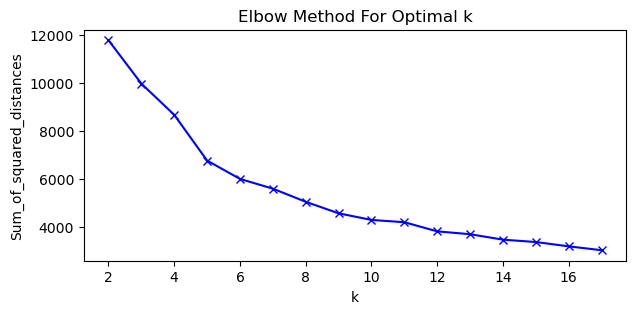

In [65]:
fig = plt.figure(figsize = (7,3))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

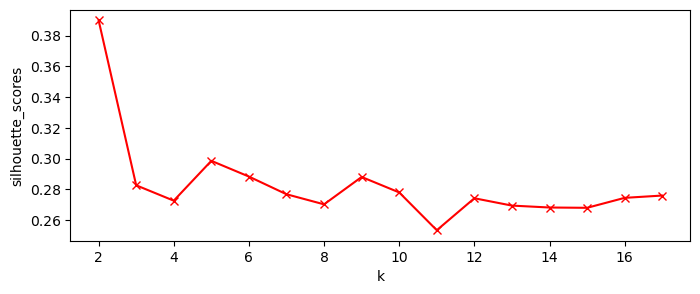

In [66]:
fig = plt.figure(figsize = (8,3))
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('silhouette_scores')
plt.show()

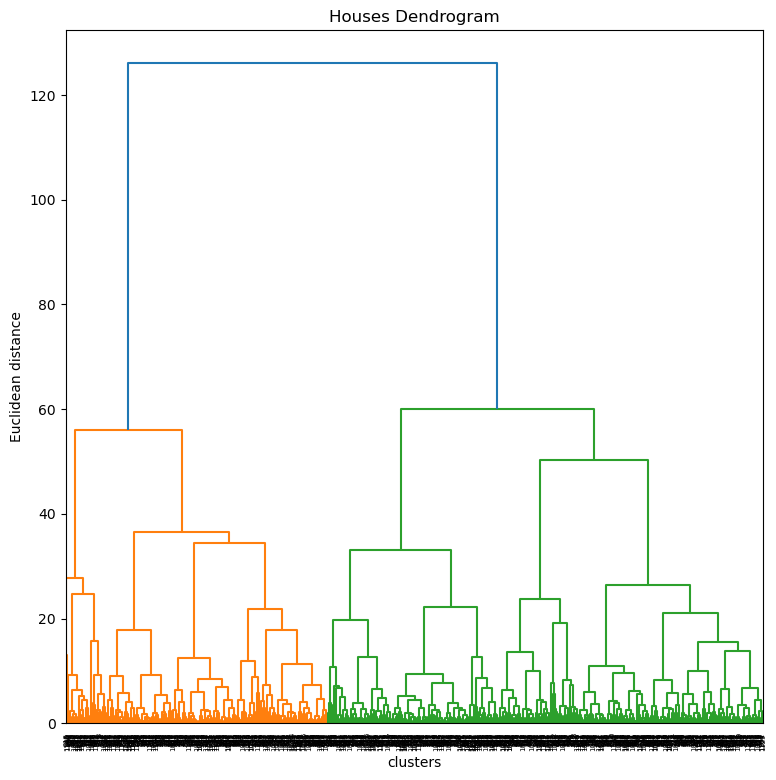

In [67]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize = (9,9))
dendogram_plot = dendrogram(linkage(pca_data_standard, method = 'ward' ))
plt.title('Houses Dendrogram')
plt.xlabel('clusters')
plt.ylabel('Euclidean distance')
plt.show()

In [68]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(pca_data_standard)
print(silhouette_score(pca_data_standard, y_hc))
features2['hc_pca'] = y_hc

0.38208437880572393
